In [22]:
nevecs = 60
ncomps = 500
nbasecomps = 20
crop_size=180
ncauses = 2
dr_method = 'PCA'

In [23]:
from pathlib import Path
import os, sys

In [24]:

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')

exp_name = 'far_bias'

train_csv_path = macaw_path/'splits'/'train.csv'
train_img_path = macaw_path/'no_bias'/'train'

# test_csv_path = macaw_path/'data'/'ukbb'/'test_hc.csv'
# test_img_path = macaw_path/'data'/'ukbb'/'axial'/'test_hc'
# 
pca_path = macaw_path/exp_name/f'train_hc_pca_{ncomps}.pkl'
# 
train_path = macaw_path/exp_name/f'train_hc_data_PCA_{ncomps}.pkl'
# test_path = macaw_path/'data'/'ukbb'/'axial'/f'test_hc_data_PCA_{ncomps}.pkl'
model_base_path = macaw_path/'models'/exp_name/f'{dr_method}_{ncomps}'/f'{nevecs}'

if not os.path.exists(model_base_path):
    os.makedirs(model_base_path)

In [25]:
import pickle

with open(train_path, 'rb') as f:
    train = pickle.load(f)
    
disease = train['disease']
bias = train['bias']

encoded_data = train['encoded_data']
pca = train['pca']

In [26]:
encoded_data.shape

(1005, 500)

In [27]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

[Text(0.5, 1.0, 'disease')]

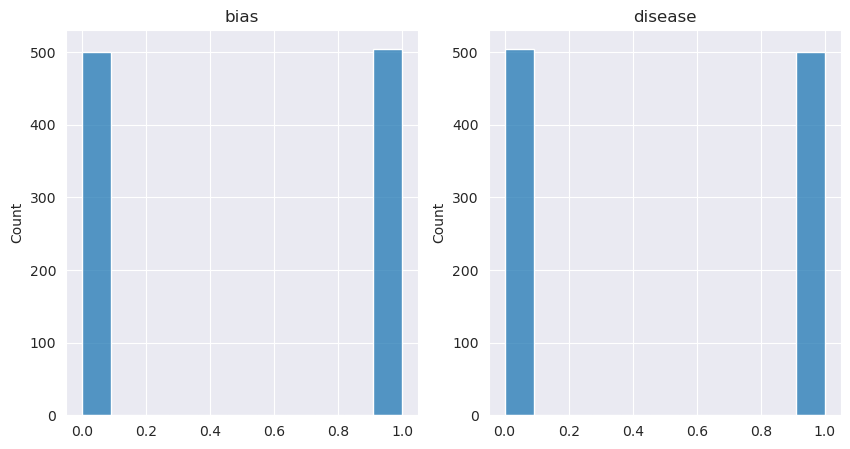

In [28]:
import seaborn as sns

sb = 2
fig, axs = plt.subplots(1,sb, figsize=(sb*5,5))

sns.histplot(bias,ax=axs[0],fill=True)
axs[0].set(title = "bias")
sns.histplot(disease,ax=axs[1], fill=True)
axs[1].set(title="disease")
# sns.histplot(encoded_data[0],ax=axs[3], fill=True)
# axs[3].set(title="PCA0")

## Causal Graph

In [29]:
disease_to_latents = [(0,i) for i in range(ncauses,nevecs+ncauses)]

bias_to_latents = [(1,i) for i in range(ncauses,nevecs+ncauses)]

autoregressive_latents = [(i,j) for i in range(ncauses,nevecs+ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = [(i,j) for i in range(ncauses,2*ncauses) for j in range(i+1,nevecs+ncauses)]
# autoregressive_latents = []
edges = disease_to_latents + bias_to_latents + autoregressive_latents

## Priors

In [30]:
P_bias = np.sum(bias)/len(bias)
print(P_bias)

P_dis = np.sum(disease)/len(disease)
print(P_dis)

0.5024875621890548
0.4975124378109453


In [31]:
import torch
import yaml
from utils.helpers import dict2namespace

with open(macaw_path/'config'/'ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [32]:
torch.cuda.is_available()

True

In [33]:
config.device

device(type='cuda')

In [34]:
import torch.distributions as td

priors = [(slice(0,1),td.Bernoulli(torch.tensor([P_bias]).to(torch.device(config.device)))), # bias
          (slice(1,2),td.Bernoulli(torch.tensor([P_dis]).to(torch.device(config.device)))), # disease
          (slice(nbasecomps+2,nevecs+2),td.Normal(torch.zeros(nevecs-nbasecomps).to(torch.device(config.device)), torch.ones(nevecs-nbasecomps).to(torch.device(config.device)))), # new_comps
         ]

In [35]:
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

In [36]:
loss_vals = []

In [40]:
from macaw import MACAW

for e in range(0,479,nevecs-nbasecomps):
    save_path = model_base_path/f'{e}.pt'    
    ed =  encoded_data[:,e:e+nevecs]
    print(e,e+nevecs)
    
    if not os.path.exists(save_path): 
       
        X = np.hstack([bias[:,np.newaxis], disease[:,np.newaxis], ed])    

        macaw = MACAW.MACAW(config)
        loss_vals.append(macaw.fit_with_priors(X,edges, priors))

        torch.save(macaw,save_path)
    else:
        print("Skipping")

0 60


  0%|          | 0/50 [00:00<?, ?it/s]

40 100


  0%|          | 0/50 [00:00<?, ?it/s]

80 140


  0%|          | 0/50 [00:00<?, ?it/s]

120 180


  0%|          | 0/50 [00:00<?, ?it/s]

160 220


  0%|          | 0/50 [00:00<?, ?it/s]

200 260


  0%|          | 0/50 [00:00<?, ?it/s]

240 300


  0%|          | 0/50 [00:00<?, ?it/s]

280 340


  0%|          | 0/50 [00:00<?, ?it/s]

320 380


  0%|          | 0/50 [00:00<?, ?it/s]

360 420


  0%|          | 0/50 [00:00<?, ?it/s]

400 460


  0%|          | 0/50 [00:00<?, ?it/s]

440 500


  0%|          | 0/50 [00:00<?, ?it/s]

In [41]:
loss_vals

[([4357.155776977539,
   4261.30770111084,
   4158.14005279541,
   4035.116142272949,
   3874.6436653137207,
   3651.7027320861816,
   3327.095844268799,
   2852.842540740967,
   2244.290725708008,
   1709.8396396636963,
   1133.7023134231567,
   615.951774597168,
   117.36667394638062,
   -347.17776679992676,
   -742.3579611778259,
   -1056.1162776947021,
   -1307.2970066070557,
   -1516.3980655670166,
   -1686.997423171997,
   -1840.7844543457031,
   -1967.123127937317,
   -2076.416624069214,
   -2175.0854721069336,
   -2266.63374710083,
   -2354.60502243042,
   -2440.522678375244,
   -2526.1086950302124,
   -2616.1639404296875,
   -2710.4603328704834,
   -2810.9095497131348,
   -2921.357921600342,
   -3045.5230255126953,
   -3185.5893726348877,
   -3346.7899322509766,
   -3534.916187286377,
   -3754.641613006592,
   -4017.42378616333,
   -4333.17497253418,
   -4713.475830078125,
   -5179.576042175293,
   -5733.8417892456055,
   -6393.8535079956055,
   -7169.183906555176,
   -8108.81

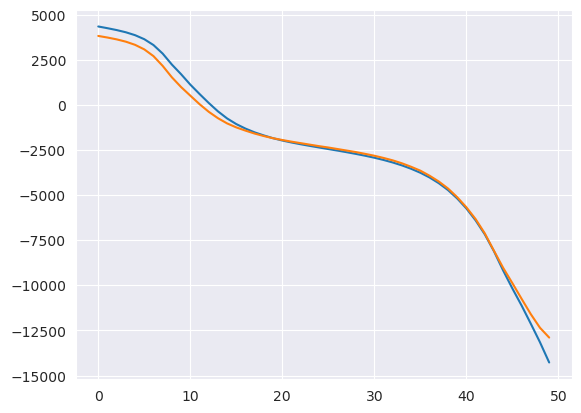

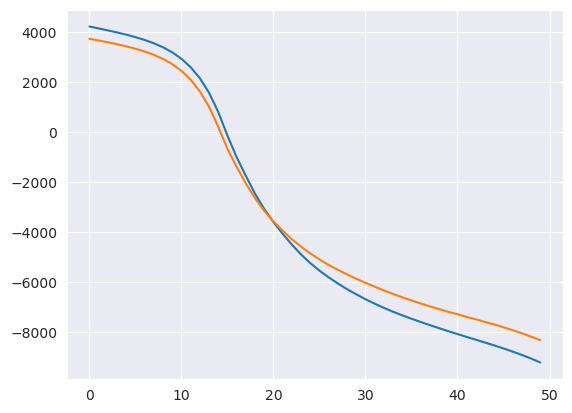

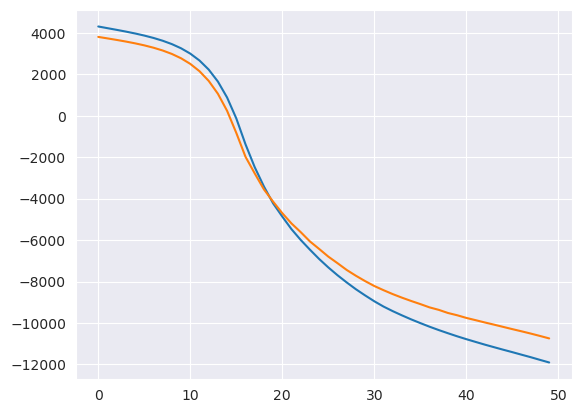

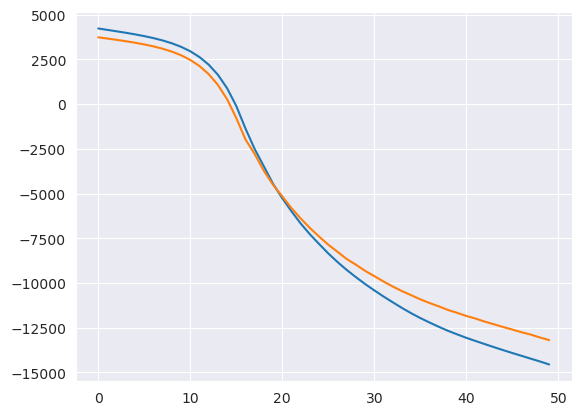

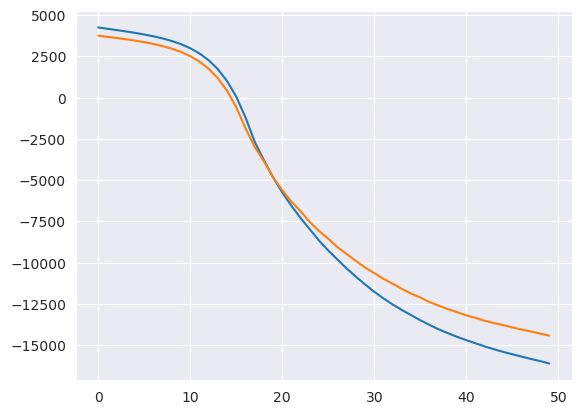

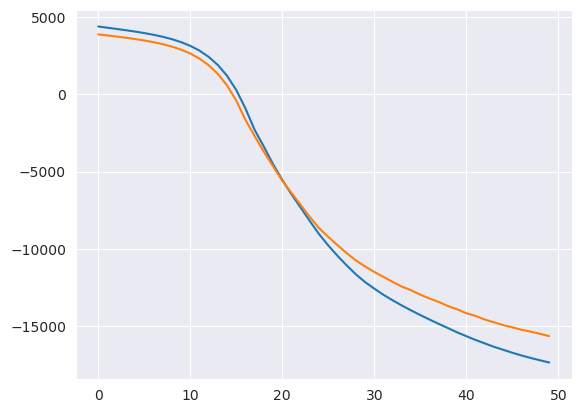

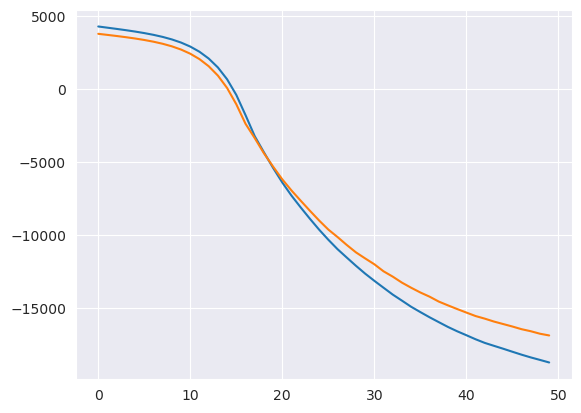

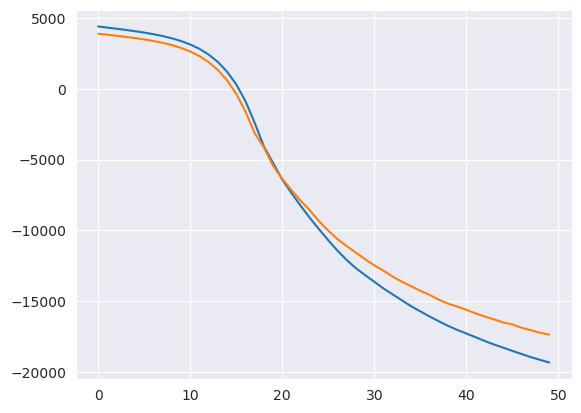

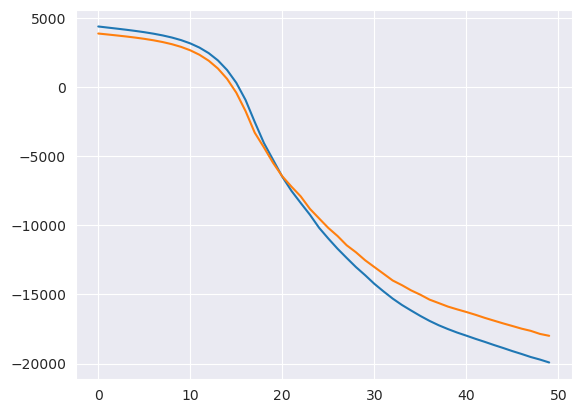

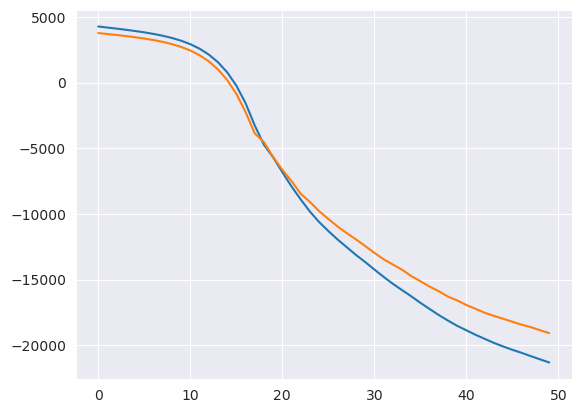

In [42]:
for i in range(10):
    plt.figure(i)  # Create a new figure for each plot
    plt.plot(np.array(loss_vals[i][0]))
    plt.plot(np.array(loss_vals[i][1]))
    plt.show()  # Display the plot

In [43]:
model_path = model_base_path/'hyperparameters.pkl'

with open(model_path, 'wb') as f:
    pickle.dump({'ncomps':ncomps, 'nevecs':nevecs,'nbasecomps':nbasecomps, 'ncauses':ncauses, 'crop_size':crop_size}, f)

## Linear regression

In [ ]:
import torch
import yaml
from utils.helpers import dict2namespace

with open(macaw_path/'config'/'ukbb.yaml', 'r') as f:
    config_raw = yaml.load(f, Loader=yaml.FullLoader)
    
config = dict2namespace(config_raw)
config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
ed =  encoded_data[:,:nevecs]
X = np.hstack([sex[:,np.newaxis], bmi[:,np.newaxis], ed])    

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, age)

In [ ]:
reg.score(X, age)

In [ ]:
lr_path = model_base_path/'lr.pkl'

with open(lr_path, 'wb') as f:
    pickle.dump({'reg':reg}, f)

In [ ]:
lr_path

In [ ]:
reg.coef_

In [ ]:
np.mean(np.abs(reg.predict(X) - age))

In [ ]:
idx = 0
macaw = torch.load(model_base_path/f'{idx}.pt')
X_test = np.hstack([sex[:,np.newaxis], age[:,np.newaxis], bmi[:,np.newaxis], encoded_data[:,idx:nevecs+idx]])

In [ ]:
encoded_data.shape

In [ ]:
probs=[]
for i in range(36):
    X_test[:,1] = i
    probs.append(macaw.log_likelihood(X_test))

In [ ]:
pexp = np.exp(np.array(probs))
pexp_sum = np.sum(pexp,axis=0)
p = pexp/pexp_sum

In [ ]:
pred_labels = np.argmax(probs, axis=0)

In [ ]:
age_bins=36

In [ ]:
sns.histplot(age, bins=age_bins)
sns.histplot(pred_labels,bins=age_bins)

In [ ]:
l = np.array(probs)[:,80]
plt.bar(np.arange(36),l-np.min(l))

In [ ]:
sns.histplot(age-pred_labels, bins=age_bins)

In [ ]:
np.mean(np.abs(pred_labels - age))